In [1]:
import os
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
from HW_2.data_loader import DataLoader
from HW_2.visualization import DataVisualization


Таблица уже содержит 1460 строк. Insert пропущен.


Теперь выполним пару простых запросов:


Фильтрация по YearBuilt:

     house_id street  yearbuilt  lotarea foundation heating  firstflrsf  \
0           1   Pave       2003   8450.0      PConc    GasA       856.0   
1           3   Pave       2001  11250.0      PConc    GasA       920.0   
2           5   Pave       2000  14260.0      PConc    GasA      1145.0   
3           7   Pave       2004  10084.0      PConc    GasA      1694.0   
4          12   Pave       2005  11924.0      PConc    GasA      1182.0   
..        ...    ...        ...      ...        ...     ...         ...   
383      1445   Pave       2004   8500.0      PConc    GasA      1422.0   
384      1452   Pave       2008   9262.0      PConc    GasA      1578.0   
385      1453   Pave       2005   3675.0      PConc    GasA      1072.0   
386      1454   Pave       2006  17217.0      PConc    GasA      1140.0   
387      1455   Pave       2004   7500.0      PConc    

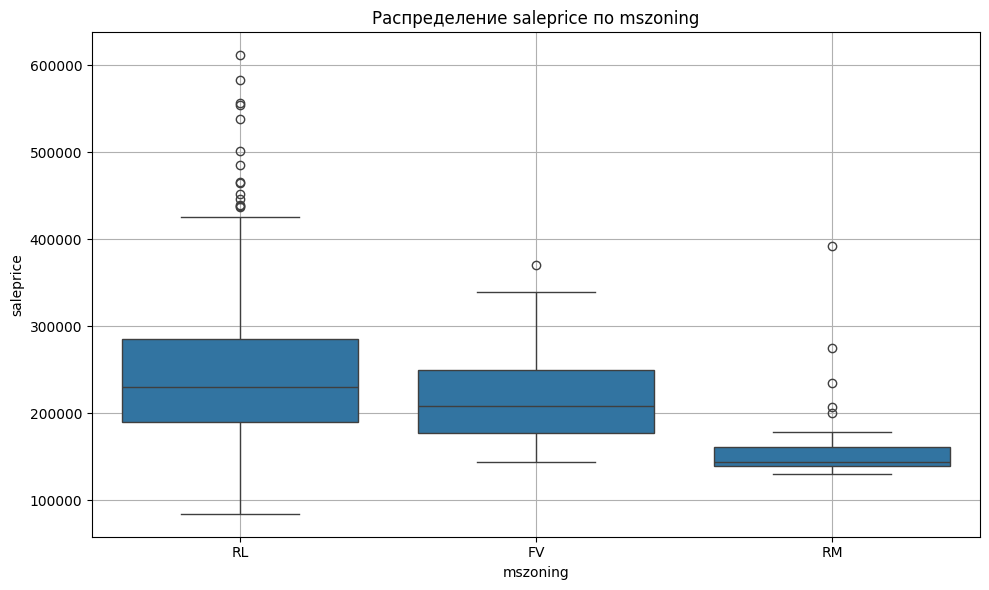

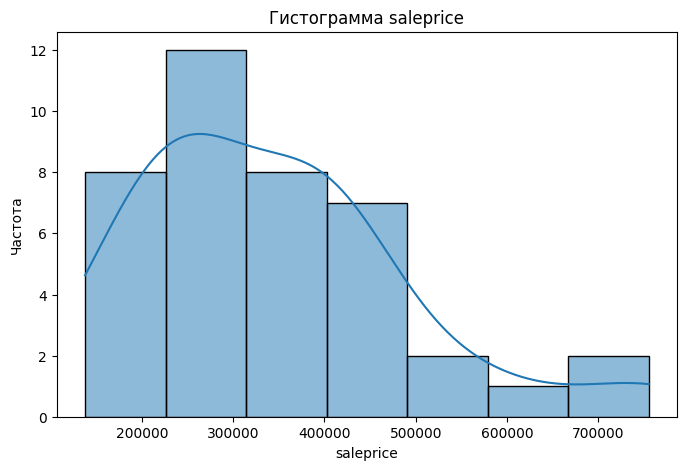

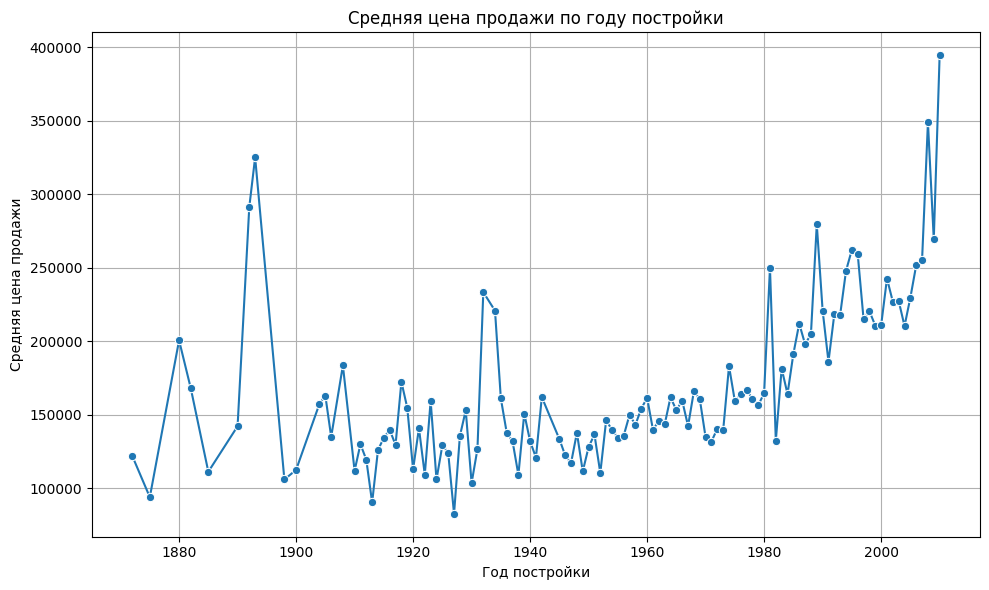

In [2]:
if __name__ == "__main__":
    try:
        load_dotenv()  # Загружает .env в переменные окружения

        db_name = os.getenv("DB_NAME")
        db_user = os.getenv("DB_USER")
        db_pass = os.getenv("DB_PASSWORD")
        db_host = os.getenv("DB_HOST")
        db_port = os.getenv("DB_PORT")
        # Подключаемся к базе данных
        conn = psycopg2.connect(
            dbname=db_name,  # Имя базы данных
            user=db_user,  # Имя пользователя
            password=db_pass,  # Пароль
            host=db_host,  # Адрес сервера
            port=db_port  # Порт по умолчанию для PostgreSQL
        )

        # Создаем курсор для выполнения SQL-запросов
        cursor = conn.cursor()

        # Запрос для создания таблицы
        create_table_query = """
            CREATE TABLE IF NOT EXISTS Houses (
                house_id SERIAL PRIMARY KEY,
                Street VARCHAR(255) NOT NULL,
                YearBuilt INT NOT NULL,
                LotArea DECIMAL(10,2) NOT NULL CHECK (LotArea >= 0),
                Foundation VARCHAR(50) NOT NULL,
                Heating VARCHAR(50) NOT NULL,
                firstFlrSF DECIMAL(10,2) NOT NULL CHECK (firstFlrSF >= 0),
                secondFlrSF DECIMAL(10,2) NOT NULL CHECK (secondFlrSF >= 0),
                BedroomAbvGr DECIMAL(10,2) NOT NULL CHECK (BedroomAbvGr >= 0),
                KitchenAbvGr DECIMAL(10,2) NOT NULL CHECK (KitchenAbvGr >= 0),
                OverallQual INT NOT NULL,
                OverallCond INT NOT NULL,
                MSZoning VARCHAR(50) NOT NULL,
                KitchenQual VARCHAR(50) NOT NULL,
                SalePrice DECIMAL(10,2) NOT NULL CHECK (SalePrice >= 0)
            );
            """

        cursor.execute(create_table_query)
        conn.commit()

        # Проверка таблицы на пустоту
        cursor.execute("SELECT COUNT(*) as row_count FROM Houses;")
        row_count = cursor.fetchone()[0]

        if row_count == 0:
            print("\nТаблица пустая. Заполяним ее данными из выбранного датасета...")

            # Подготавливаем данные для загрузки
            columns = ['Street', 'YearBuilt', 'LotArea', 'Foundation', 'Heating', '1stFlrSF', '2ndFlrSF',
                       'BedroomAbvGr',
                       'KitchenAbvGr', 'OverallQual', 'OverallCond', 'MSZoning', 'KitchenQual', 'SalePrice']

            cwd = os.getcwd()
            file_path = os.path.join(cwd, r'hw_3_data\train.csv')  # Замените на путь к вашему CSV файлу

            data = DataLoader.load_from_csv(file_path)

            data_subset = data[columns]

            data_tuples = list(data_subset.itertuples(index=False, name=None))

            insert_query = """INSERT INTO Houses (Street, YearBuilt, LotArea, Foundation, Heating, firstFlrSF,
                    secondFlrSF, BedroomAbvGr, KitchenAbvGr, OverallQual, OverallCond, MSZoning, KitchenQual, SalePrice) VALUES (%s,
                    %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);"""

            cursor.executemany(insert_query, data_tuples)
            conn.commit()
        else:
            print(f"\nТаблица уже содержит {row_count} строк. Insert пропущен.\n")

        print("\nТеперь выполним пару простых запросов:\n")

        engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}")

        print("\nФильтрация по YearBuilt:\n")

        YearBuilt_query = "SELECT * FROM Houses where YearBuilt between 2000 and 2025;"

        YearBuilt_query_df = pd.read_sql(YearBuilt_query, engine)
        print(YearBuilt_query_df)

        print("\nФильтрация по firstFlrSF:\n")

        firstFlrSF_query = "SELECT house_id, firstFlrSF, SalePrice FROM Houses where firstFlrSF > 2000;"

        firstFlrSF_query_df = pd.read_sql(firstFlrSF_query, engine)
        print(firstFlrSF_query_df)

        print("\nФильтрация по MSZoning:\n")

        MSZoning_query = "SELECT house_id, MSZoning, SalePrice FROM Houses where MSZoning in ('RM', 'FV');"

        MSZoning_query_df = pd.read_sql(MSZoning_query, engine)
        print(MSZoning_query_df)

        print("\nТеперь выполним пару сложных запросов:")

        print("\nГруппировка по MSZoning:\n")

        MSZoning_grouping_query = "SELECT MSZoning, count(*) as houses_count, avg(SalePrice) as avg_sale_price FROM " \
                                  "Houses where " \
                                  "YearBuilt between 2000 and 2025 group by " \
                                  "MSZoning;"

        MSZoning_grouping_df = pd.read_sql(MSZoning_grouping_query, engine)
        print(MSZoning_grouping_df)

        print("\nГруппировка по KitchenQual:\n")

        KitchenQual_grouping_query = "SELECT KitchenQual, count(*) as houses_count, avg(SalePrice) as avg_sale_price, " \
                                     "max(SalePrice) as max_sale_price, min(SalePrice) as min_sale_price FROM Houses " \
                                     "where " \
                                     "LotArea > 8000 and Foundation = 'PConc' group by " \
                                     "KitchenQual order by avg_sale_price desc;"

        KitchenQual_grouping_df = pd.read_sql(KitchenQual_grouping_query, engine)
        print(KitchenQual_grouping_df)

        YearBuilt_grouping_query = "SELECT YearBuilt, avg(SalePrice) as avg_sale_price " \
                                   "FROM Houses group by YearBuilt;"

        YearBuilt_grouping_df = pd.read_sql(YearBuilt_grouping_query, engine)
        print(YearBuilt_grouping_df)

        DataVisualization.plot_boxplot(YearBuilt_query_df, "mszoning", "saleprice")
        DataVisualization.plot_histogram(firstFlrSF_query_df, "saleprice")
        DataVisualization.plot_price_by_year_built(YearBuilt_grouping_df)

    except Exception as e:
        print(f"{e}")
    finally:
        cursor.close()
        conn.close()
